## GMSNetのモデルを作成する  train,eval,test のデータに分ける
### 損失関数の求め方、必要な値が正しく得られているかなど検証してみる
2024/5/17 時点での完成版

コードをすべて問題なく実行できるようにはなった。
最適化されたメッシュを取り出してくることもでき、しっかり更新できている。
しかし、損失の値が全く減少せず、むしろ増加していてほぼもともとのメッシュのままの出力が最適化メッシュとして出てきてしまう。
ゆえに、最適化できているとは到底言えない。





# シフト切り捨てをやめてみる
# トレーニング完了後のトレーニングメッシュを表示してみる
# 各epochの終了時にメッシュを可視化してみる

In [2]:
import copy
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.nn import GCNConv
from torch_geometric.nn.norm import GraphNorm
import torch_geometric.transforms as T
from torch.nn import Linear, InstanceNorm2d, InstanceNorm1d
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
import matplotlib.pyplot as plt
from torch_geometric.transforms import FaceToEdge
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from itertools import combinations
import vtk
import glob
from torch_scatter import scatter_mean
from tqdm import tqdm
# 計算を軽くするためのライブラリ
from torch.cuda import empty_cache
import gc               # メモリリークを防ぐ

ModuleNotFoundError: No module named 'torch_scatter'

In [ ]:
torch.cuda.is_available()

True

In [ ]:
num_train_epoch = 20
num_test_epoch = 100
num_trial = 2

# Dataの準備

In [ ]:
class Dataset(Dataset):
    def __init__(self, num_files):
        None

class Mesh(Dataset):
    def __init__(self):
        self.coordinates = None
        self.faces = None

class Polygon(Dataset):
    def __init__(self, num_node, num_face):
        self.parent_meshID = None
        self.coordinates = torch.zeros(num_node, 2)
        self.faces = torch.zeros(num_face, 3)
        self.edges = None
        self.d = None
        self.Cx = None
        self.Cy = None
        self.x_min = None
        self.y_min = None

class PolygonID(Dataset):
    def __init__(self, nodeID):
        self.nodeID = nodeID
        # self.parent_meshID = None

class Polygon_data(Dataset):
    def __init__(self, polygonID, meshID, nodeID):
        self.polygonID = polygonID
        self.meshID = meshID
        self.nodeID = nodeID

class Minibatch(Dataset):
    def __init__(self):
        self.x = None
        self.edge_index = None
        self.batch = None

In [ ]:
def create_mesh_polygonID_data(vtk_file_path, polygonID_list, poly_count, polygon_dict, mesh_index):
    reader = vtk.vtkDataSetReader()
    reader.SetFileName(vtk_file_path)
    reader.Update()

    data = reader.GetOutput()
    
    mesh = Mesh()
    # 座標情報を取得
    points = data.GetPoints()
    num_points = points.GetNumberOfPoints()
    coordinates = torch.zeros(num_points, 3)
    for i in range(num_points):
        coordinates[i] = torch.tensor(points.GetPoint(i))

    mesh.coordinates = coordinates[:, :2]                        # mesh.coordinates を定義

    # 面情報を取得
    polys = data.GetPolys()
    num_polys = polys.GetNumberOfCells()
    mesh.faces = torch.zeros(num_polys, 3, dtype=int)           # mesh.faces を定義

    # 各三角形の情報を取得
    polys.InitTraversal()
    for i in range(num_polys):
        cell = vtk.vtkIdList()
        if polys.GetNextCell(cell) == 0:
            break
        mesh.faces[i] = torch.tensor([cell.GetId(0), cell.GetId(1), cell.GetId(2)])
        
# ------------ mesh のデータを取得完了 -------------------------


    # 各セルの各辺の隣接セル数を調べる
    edge_neighbors = {}
    num_cells = data.GetNumberOfCells()
    for cell_index in range(num_cells):
        cell = data.GetCell(cell_index)
        num_edges = cell.GetNumberOfEdges()

        for edge_index in range(num_edges):
            edge = cell.GetEdge(edge_index)
            edge_points = edge.GetPointIds()

            # 辺を構成する点のインデックスを取得
            point1_id = edge_points.GetId(0)
            point2_id = edge_points.GetId(1)

            # 辺を構成する点のインデックスを照準にソート
            edge_key = (min(point1_id, point2_id), max(point1_id, point2_id))

            # 辺の隣接セル数をカウント
            if edge_key in edge_neighbors:
                edge_neighbors[edge_key] += 1
            else:
                edge_neighbors[edge_key] = 1 

    boundary_edges = []
    # 境界上の辺を特定
    for edge_key, num_neighbors in edge_neighbors.items():
        if num_neighbors == 1:
            boundary_edges.append(edge_key)

    # 境界上の辺を構成する頂点の番号を取得
    boundary_points = set()     # 集合を表すデータ型、順番を持たず、重複した要素は取り除かれる
# ---------------- 自由点かどうかの判定完了 ------------------------
    

    for edge_key in boundary_edges:
        boundary_points.add(edge_key[0])
        boundary_points.add(edge_key[1])
    
    
    for pointId in range(num_points):       # pointId:自由点の頂点番号
        if pointId in boundary_points:
            continue
        else:
            poly_count += 1
            # print("pointId:", pointId)
        mask = (mesh.faces == pointId)
        if mask.any():
            count = torch.sum(mask).item()
        num_node = count + 1
        num_face = count
        polygon_number = poly_count - 1 



        
        polygon_i = f"polygon_{polygon_number}"
        # print(polygon_i)
        polygon_i = Polygon(num_node, num_face)
        
        element_to_check = pointId
        polygon_i.face = mesh.faces[(mesh.faces == element_to_check).any(dim=1)]
        # print(polygon_i.face)

        polygon_i.nodeId = set()
        for i in range(len(polygon_i.face)):
            polygon_i.nodeId.add(polygon_i.face[i, 0].item())
            polygon_i.nodeId.add(polygon_i.face[i, 1].item())
            polygon_i.nodeId.add(polygon_i.face[i, 2].item())
        sorted_nodeId = sorted(polygon_i.nodeId)
        polygon_i.nodeID = torch.tensor(list(sorted_nodeId))
        
        point_id_index = (polygon_i.nodeID == pointId).nonzero().item()

        value_to_move = polygon_i.nodeID[point_id_index]
        polygon_i.nodeID = torch.cat((value_to_move.unsqueeze(0), polygon_i.nodeID[polygon_i.nodeID != pointId]))
        # print(polygon_i.nodeID)
        setattr(polygon_i, "parent_meshID", mesh)
        polygonID_list.append(f"polygon_{polygon_number}")

        keyword = f"polygon_{polygon_number}"
        valiables = (f"mesh_{mesh_index}", polygon_i.nodeID)
        polygon_dict[keyword] = valiables

    # --------- polygon.nodeID の取得完了 -------------
    return mesh, polygonID_list, poly_count, polygon_dict

# Dataset の作成

In [ ]:
def create_mesh_polygon_dataset(vtk_files):
    num_vtk_files = len(vtk_files)
    polygonID_list = []
    mesh_data_list = []
    poly_count = 0
    polygon_dict = {}
    # ファイルに順にアクセスする
    for i in range(num_vtk_files):
        # print("File Name:", vtk_files[i])
        mesh, polygonID_list, poly_count, polygon_dict = create_mesh_polygonID_data(vtk_files[i], polygonID_list, poly_count, polygon_dict, i)
        mesh_data_list.append(mesh)
    return mesh_data_list, polygonID_list, polygon_dict


In [ ]:
# 以下、i はpolygon番号で座標と面情報を取得することができる
face_to_edge = T.FaceToEdge(remove_faces=False)
def data_getter(polygonID, num_mesh_data_list, mesh_data_list, polygon_data_list):
    
    polygon_meshID = int(polygon_data_list[polygonID].meshID.split("_")[-1])
    mesh = mesh_data_list[polygon_meshID]
    
    num_node = len(polygon_data_list[polygonID].nodeID)
    num_face = num_node - 1 
    polygon_i = Polygon(num_node, num_face)

    # print(polygon_data_list[polygonID].nodeID)      # polygon に属する頂点の番号

    polygon_i.coordinates = mesh.coordinates[polygon_data_list[polygonID].nodeID]     # polygonの座標
    # print(polygon_i.coordinates)

    # print(polygon_i.faces)

    # polygon_i.faces を取得するコード
    
    element_to_check = polygon_data_list[polygonID].nodeID[0]
    polygon_i.face = mesh.faces[(mesh.faces == element_to_check).any(dim=1)]

    indices = torch.nonzero(torch.isin(polygon_i.face, polygon_data_list[polygonID].nodeID))
    for idx in range(indices.size(0)):
        row_idx, col_idx = indices[idx]
        value_to_replace = polygon_i.face[row_idx, col_idx]
        polygon_i.face[row_idx, col_idx] = (polygon_data_list[polygonID].nodeID == value_to_replace).nonzero().item()
    polygon_i.faces = polygon_i.face.long()

    # 各行の三角形からエッジを抽出してedge_indexを構築
    edges = torch.cat([ polygon_i.faces[:, [0, 1]],
                        polygon_i.faces[:, [1, 2]],
                        polygon_i.faces[:, [2, 0]]], dim=0)

    # エッジのインデックスをソートして重複を削除
    edge_index = torch.tensor(sorted(edges.numpy().tolist())).unique(dim=0)
    polygon_i.edge_index = torch.transpose(edge_index, 0, 1)
    return polygon_i



# メッシュをプロットする関数

In [ ]:
def plot_mesh(mesh, title):

    vertices = mesh.coordinates
    faces = mesh.faces
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect="equal")

    # 描画するメッシュの頂点をプロット
    # ax.plot(vertices[:,0], vertices[:,1], 'bo')  # 頂点を青色の点でプロット
    # ax.plot(vertices[:,0], vertices[:,1], 'k-')  # 辺を黒色の線でプロット

    # 各三角形をプロット
    for face in faces:
        v0, v1, v2 = vertices[face]
        v0_np = v0.detach().numpy()
        v1_np = v1.detach().numpy()
        v2_np = v2.detach().numpy()
        ax.plot([v0_np[0], v1_np[0], v2_np[0], v0_np[0]], [v0_np[1], v1_np[1], v2_np[1], v0_np[1]], 'b-')  # 三角形を赤色の線でプロット

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axhline(0, color="black", linewidth=0.001)
    ax.axvline(0, color="black", linewidth=0.001)

    # plt.xlim(-300, 150)
    # plt.ylim(-200, 1400)
    # plt.savefig(f"/mnt/{title}.png", format="png")
    plt.show()
    plt.close()


In [ ]:
def save_mesh(mesh, title):

    vertices = mesh.coordinates
    faces = mesh.faces
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect="equal")

    # 描画するメッシュの頂点をプロット
    # ax.plot(vertices[:,0], vertices[:,1], 'bo')  # 頂点を青色の点でプロット
    # ax.plot(vertices[:,0], vertices[:,1], 'k-')  # 辺を黒色の線でプロット

    # 各三角形をプロット
    for face in faces:
        v0, v1, v2 = vertices[face]
        v0_np = v0.detach().numpy()
        v1_np = v1.detach().numpy()
        v2_np = v2.detach().numpy()
        ax.plot([v0_np[0], v1_np[0], v2_np[0], v0_np[0]], [v0_np[1], v1_np[1], v2_np[1], v0_np[1]], 'b-')  # 三角形を赤色の線でプロット

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.axhline(0, color="black", linewidth=0.001)
    ax.axvline(0, color="black", linewidth=0.001)

    # plt.xlim(-300, 150)
    # plt.ylim(-200, 1400)
    plt.savefig(f"/mnt/Saved_mesh/{title}.png", format="png")
    # plt.show()
    plt.close()

# meshデータからvtkファイルを出力する関数

In [ ]:
def vtk_output(mesh, title):
    vertices = mesh.coordinates
    faces = mesh.faces
    num_vertices = len(vertices)
    num_faces = len(faces)


    # vertices を３次元に戻す
    z_column = torch.zeros(vertices.shape[0], 1)
    vertices = torch.cat((vertices, z_column), dim=1)

    with open(f"/mnt/optimized_data/{title}.vtk", "w") as f:
        f.write("# vtk DataFile Version 2.0\n")
        f.write("FOR TEST\n")
        f.write("ASCII\n")
        f.write("DATASET POLYDATA\n")

        f.write("POINTS {} float\n".format(num_vertices))
        for vertex in vertices:
            f.write("{:.15f} {:.15f} {:.15f}\n".format(*vertex))

        f.write("\nPOLYGONS {} {}\n".format(num_faces, num_faces * 4))
        for face in faces:
            f.write("3 ")
            f.write(" ".join(str(idx.item()) for idx in face))
            f.write("\n")
       



# Normalization

In [ ]:
def normalization(polygon):
    vertices = polygon.coordinates
    normalized_vertices = vertices.clone()
    centered_vertices = vertices.clone()
    # print(vertices)

    max_x = torch.max(vertices[:,0])
    min_x = torch.min(vertices[:,0])
    max_y = torch.max(vertices[:,1])
    min_y = torch.min(vertices[:,1])

    polygon.d = torch.max(max_x - min_x, max_y - min_y)
    polygon.x_min = min_x
    polygon.y_min = min_y

    normalized_vertices = (vertices - torch.tensor([polygon.x_min, polygon.y_min])) / polygon.d

    
    polygon.Cx = normalized_vertices[0,0].item()
    polygon.Cy = normalized_vertices[0,1].item()   

    centered_vertices = normalized_vertices - torch.tensor([polygon.Cx, polygon.Cy])
    polygon.coordinates = centered_vertices
    
    # print("Normalized polygon:", vertices)

    return polygon


    


# denormalization

In [ ]:
def denormalization(polygon):
    vertices = polygon.coordinates
    shifted_vertices = vertices.clone()
    denormalized_vertices = vertices.clone()
    
    shifted_vertices = vertices + torch.tensor([polygon.Cx, polygon.Cy])
        

    denormalized_vertices = polygon.d * shifted_vertices + torch.tensor([polygon.x_min, polygon.y_min])
    polygon.coordinates = denormalized_vertices
    return polygon


# MetricLoss

In [ ]:
class MetricLoss:
    def select_vertices(self, vertices, face):
        v0 = vertices[face[0]]
        v1 = vertices[face[1]]
        v2 = vertices[face[2]]
        return v0, v1, v2 

    def edge_length(self, v0, v1, v2):
        l1 = torch.sqrt((v0[0] - v1[0])**2 + (v0[1] - v1[1])**2)
        l2 = torch.sqrt((v1[0] - v2[0])**2 + (v1[1] - v2[1])**2)
        l3 = torch.sqrt((v2[0] - v0[0])**2 + (v2[1] - v0[1])**2)

        return l1, l2, l3

    def face_area(self, l1, l2, l3):
        s = (l1 + l2 + l3)/2
        face_area = torch.sqrt(s*(s-l1)*(s-l2)*(s-l3))
        return face_area

    def compute_loss(self, vertices, face):
        v0, v1, v2 = self.select_vertices(vertices, face)
        l1, l2, l3 = self.edge_length(v0, v1, v2)
        s = self.face_area(l1, l2, l3)

        q = (l1**2 + l2**2 + l3**2)/(4.0*torch.sqrt(torch.tensor(3.))*s)
        q = q.clone().detach().requires_grad_(True)
        return 1-1/q

    def __call__(self, polygon):
        vertices = polygon.coordinates
        faces = polygon.faces
        loss = 0 
        for face in faces:
            loss = loss + self.compute_loss(vertices, face)
        
        metric_loss = ((loss/(len(polygon.coordinates[:,0])-1)).clone().detach().requires_grad_(True))
        return metric_loss
    



# meshデータからq_hatを求める関数

In [ ]:
def calculate_q_hat(mesh):
    vertices = mesh.coordinates
    faces = mesh.faces
    r_list = []
    alpha_list = []
    beta_list = []

    for face in faces:
        # a(最小角)と b(最大角)を求める

        angles = []
        v0, v1, v2 = m_loss.select_vertices(vertices, face)
        l1, l2, l3 = m_loss.edge_length(v0, v1, v2)

        # 余弦定理から各角度の余弦値を計算
        cos_alpha = (l2**2 + l3**2 - l1**2) / (2*l2*l3)
        cos_beta = (l1**2 + l3**2 - l2**2) / (2*l1*l3)
        cos_gamma = (l1**2 + l2**2 - l3**2) / (2*l1*l2)
        # 余弦値から角度を計算して個度法に変換
        alpha = torch.acos(cos_alpha) * 180 / np.pi
        beta = torch.acos(cos_beta) * 180 / np.pi
        gamma = torch.acos(cos_gamma) * 180 / np.pi

        angles.append(alpha)
        angles.append(beta)
        angles.append(gamma)

        min_angle = min(angles)
        max_angle = max(angles)

        alpha_list.append(min_angle)
        beta_list.append(max_angle)



        # 1/q = r を求める

        r = 1 - m_loss.compute_loss(vertices, face) 
        r_list.append(r)

    a_mean = sum(alpha_list) / len(alpha_list)
    a_min = min(alpha_list)
    b_mean = sum(beta_list) / len(beta_list)
    b_max = max(beta_list)
    r_mean = sum(r_list) / len(r_list)
    r_min = min(r_list)

    q_hat = (((a_mean + a_min + 120 - b_max - b_mean)/60) + r_mean + r_min) / 6

    return q_hat

    


    
    

スターポリゴンの中から外側に自由点が移動したときに自由点の移動量を半分にしてもう一度外に行っていないか検証する
自由点が外に行かないことを確認したあとのスターポリゴンを返す

In [ ]:
def check(polygon, polygonID):
    # print("polygonID:", polygonID)
    vertices = polygon.coordinates
    
    edge_index = polygon.edge_index
    
    return_value = True
    while return_value == True:   

        for i in range(1, len(vertices[:,0])):
            point1 = torch.tensor([0.0, 0.0])
            point2 = vertices[0]
            point3 = vertices[i]
            
            pos_i = torch.where(edge_index[0] == i)
            pos_i = pos_i[0]
            # print("edge_index[0]", edge_index[0])
            
            for j in range(len(pos_i)):
                if edge_index[1, pos_i[j]] == 0:
                    continue
                else:
                    val_pos_i = edge_index[1, pos_i[j]]
                    break

            point4 = vertices[val_pos_i]


            a1 = 0
            b1 = 0
            a2 = 0
            b2 = 0
            check1 = 0
            check2 = 0
            check3 = 0
            check4 = 0
            x1 = point1[0]
            y1 = point1[1]
            x2 = point2[0]
            y2 = point2[1]
            x3 = point3[0]
            y3 = point3[1]
            x4 = point4[0]
            y4 = point4[1]
            a1 = (y1 - y2)/(x1-x2)
            b1 = y1 - (a1*x1)
            a2 = (y3 - y4)/(x3-x4)
            b2 = y3 - (a2*x3)
            check1 = (a1*x3) - y3 + b1 
            check2 = (a1*x4) - y4 + b1    # point1,2を通る直線に対してpoint3,4を結ぶ線分が交差しているか
            check3 = (a2*x1) - y1 + b2
            check4 = (a2*x2) - y2 + b2    # point3,4を通る直線に対してpoint1,2を結ぶ線分が交差しているか
            # print("1:",check1,"2:",check2,"3:",check3,"4:",check4)
            del a1, a2, b1, b2, x1, x2, x3, x4, y1, y2, y3, y4 

            if (check1*check2) <= 0 and (check3*check4) <= 0 :
                return_value = True
                # print("Out_of_StarPolygon")
                vertices[0] = 0.5*vertices[0]
                polygon.coordinates[0] = vertices[0]
                break
            else:
                return_value = False
                continue       
            
        
    # plot_mesh(polygon, "polygon_checked")
               
    return polygon

# Model 隠れ層のノード数は何にするか未定

In [ ]:
num_dimensions = 2

class GMSNet(torch.nn.Module):
    def __init__(self, hidden_channnels):
        super(GMSNet, self).__init__()
        torch.manual_seed(42)
        self.lin = Linear(num_dimensions, num_dimensions)
        self.GNorm = GraphNorm(num_dimensions, num_dimensions)
        self.conv = GCNConv(num_dimensions, num_dimensions)
        self.fc1 = Linear(num_dimensions, hidden_channnels)
        self.ISNorm = InstanceNorm1d(hidden_channnels, hidden_channnels)
        self.fc2 = Linear(hidden_channnels, num_dimensions)

    def forward(self, x, edge_index, batch):       
        x = self.lin(x)
        x1 = self.GNorm(x)
        x = x1.relu()
        x = self.conv(x, edge_index) + x1 
        x = self.fc1(x)
        x = self.ISNorm(x)
        x = self.fc2(x)

        x = scatter_mean(x, batch, dim=0)   # batch内のサンプルの出力の平均を取って１つのテンソルにする

        return x


# Main

In [ ]:
# フォルダ内のすべてのvtkファイルにアクセスする
train_vtk_files = glob.glob("/mnt/Train_Data/*.vtk")
eval_vtk_files = glob.glob("mnt/Eval_Data/*.vtk")
test_vtk_files = glob.glob("mnt/Test_Data/*vtk")

num_train_mesh = len(train_vtk_files)
num_test_mesh = len(test_vtk_files)
print("num_train_mesh:", num_train_mesh)
train_mesh_data_list, train_polygonID_list, train_polygon_dict = create_mesh_polygon_dataset(train_vtk_files)
eval_mesh_data_list, eval_polygonID_list, eval_polygon_dict = create_mesh_polygon_dataset(eval_vtk_files)
test_mesh_data_list, test_polygonID_list, test_polygon_dict = create_mesh_polygon_dataset(test_vtk_files)


    
# ポリゴンデータを格納するリストを作成
train_polygon_data_list = []
eval_polygon_data_list = []
test_polygon_data_list = []

for i in range(len(train_polygonID_list)):
    polygonID = f"polygon_{i}"
    meshID = train_polygon_dict[f"polygon_{i}"][0]
    nodeID = train_polygon_dict[f"polygon_{i}"][1]
    polygon_data = Polygon_data(polygonID, meshID, nodeID)
    train_polygon_data_list.append(polygon_data)

for i in range(len(eval_polygonID_list)):
    polygonID = f"polygon_{i}"
    meshID = eval_polygon_dict[f"polygon_{i}"][0]
    nodeID = eval_polygon_dict[f"polygon_{i}"][1]
    polygon_data = Polygon_data(polygonID, meshID, nodeID)
    eval_polygon_data_list.append(polygon_data)

for i in range(len(test_polygonID_list)):
    polygonID = f"polygon_{i}"
    meshID = test_polygon_dict[f"polygon_{i}"][0]
    nodeID = test_polygon_dict[f"polygon_{i}"][1]
    polygon_data = Polygon_data(polygonID, meshID, nodeID)
    test_polygon_data_list.append(polygon_data)

num_train_mesh: 12


In [ ]:
train_data_loader = DataLoader(train_polygonID_list, batch_size=32, shuffle=True)
# eval_data_loader = DataLoader(eval_polygonID_list, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_polygonID_list, batch_size=32, shuffle=True)
# for step, data in enumerate(data_loader):
#     print(f"Step {step + 1}:")
#     print("==========")
#     print(data)
#     print(len(data))
#     for i in range(len(data)):
#         polygonID = int(data[i].split("_")[-1])
#         print("polygonID:",polygonID)
#         polygon = data_getter(polygonID, 0)
#         print("polygon.coordinates:",polygon.coordinates)
#         print("polygon.edge_index:", polygon.edge_index)
#         print("==========")
#         # plot_mesh(polygon, "title")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = GMSNet(hidden_channnels=64)
model.to(device)
print(model)
m_loss = MetricLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
criterion = MetricLoss()

cuda
GMSNet(
  (lin): Linear(in_features=2, out_features=2, bias=True)
  (GNorm): GraphNorm(2)
  (conv): GCNConv(2, 2)
  (fc1): Linear(in_features=2, out_features=64, bias=True)
  (ISNorm): InstanceNorm1d(64, eps=64, momentum=0.1, affine=False, track_running_stats=False)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
# for step, data in enumerate(train_data_loader):
#     num_dis = 0
#     all_edge_index_1 = []
#     all_edge_index_2 = []
#     for i in range(len(data)):
#         polygonID = int(data[i].split("_")[-1])
#         print(data[i])
#         print('polygonID:', polygonID)
#         polygon = data_getter(polygonID, 0, train_mesh_data_list, train_polygon_data_list)
#         plot_mesh(polygon, 'Original')
#         print(polygon.coordinates)
#         polygon = normalization(polygon)
#         plot_mesh(polygon, 'Normalized')
#         print(polygon.coordinates)
#         edge_index = polygon.edge_index + num_dis
#         all_edge_index_1.append(edge_index[0])
#         all_edge_index_2.append(edge_index[1])
#         print(all_edge_index_1)
#         print(all_edge_index_2)
#         edge_index_1 = torch.cat(all_edge_index_1, dim=-1)
#         edge_index_2 = torch.cat(all_edge_index_2, dim=-1)
#         edge_index = torch.cat([edge_index_1.unsqueeze(0), edge_index_2.unsqueeze(0)], dim=0)



In [ ]:
writer = SummaryWriter("logs")
# 学習率を調整するスケジューラの設定
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=2, factor=0.1, verbose=True)

def train(device):
    model.train()
    loss_list = []
    for step, data in enumerate(train_data_loader):
        empty_cache()
        gc.collect()
        # print(f"Step {step + 1}:")
        # print("==========")
        # print(data)
        # print(len(data))
        minibatch = Minibatch()
        minibatch_coordinates = []
        all_edge_index_1 = []
        all_edge_index_2 = []
        batch_list = []
        num_dis = 0
        metric_loss_list = []
        for i in range(len(data)):
            # gc.collect()
            polygonID = int(data[i].split("_")[-1])
            # print("polygonID:",polygonID)
            polygon = data_getter(polygonID, 0, train_mesh_data_list, train_polygon_data_list)                                                                     # 270MiB
            
            # plot_mesh(polygon, "")      #############################################

            # polygon を正規化する
            polygon = normalization(polygon)                                                                        # 900MiB
            
            # plot_mesh(polygon, "")      #############################################

            # print("polygon.coordinates:",polygon.coordinates)
            edge_index = polygon.edge_index + num_dis                               
            # print("polygon.edge_index:", edge_index)
            all_edge_index_1.append(edge_index[0])
            all_edge_index_2.append(edge_index[1])
            num_dis = num_dis + len(polygon.coordinates)
            # print("==========")
            minibatch_coordinates.append(polygon.coordinates)
            batch_i = torch.tensor([i]*len(polygon.coordinates))                    
            batch_list.append(batch_i)
            
        # print(minibatch_coordinates)
        minibatch.x = torch.cat(minibatch_coordinates, dim=0)
        
        # print(minibatch.x)
        # print("minibatch.x.size:", minibatch.x.size())
        edge_index_1 = torch.cat(all_edge_index_1, dim=-1)
        edge_index_2 = torch.cat(all_edge_index_2, dim=-1)
        minibatch.edge_index = torch.cat([edge_index_1.unsqueeze(0), edge_index_2.unsqueeze(0)], dim=0)
        # print(minibatch.edge_index)
        # print("minibatch.edge_index.size:", minibatch.edge_index.size())
        minibatch.batch = torch.cat(batch_list, dim=0)
        # print(minibatch.batch)
        # print("minibatch.batch.size:", minibatch.batch.size())

        # すべてのデータをGPU上に移動する
        minibatch.x = minibatch.x.to(device)
        minibatch.edge_index = minibatch.edge_index.to(device)
        minibatch.batch = minibatch.batch.to(device)
        model.to(device)

        out = model(minibatch.x, minibatch.edge_index, minibatch.batch)                                     # 333MiB
        # print("out:", out)
        # print("out:", out.size())

        for i in range(len(data)):
            # gc.collect()
            polygonID = int(data[i].split("_")[-1])
            polygon = data_getter(polygonID, 0, train_mesh_data_list, train_polygon_data_list)                                                             # 225MiB
            # plot_mesh(polygon, "")
            # print('Original polygon:', polygon.coordinates)
            # 正規化する
            polygon = normalization(polygon)                                                                # 932MiB
            # plot_mesh(polygon, "")
            # print('Normalized polygon:', polygon.coordinates)
            # plot_mesh(polygon, "Normalized polygon")

            polygon.coordinates[0] = out[i][]
            # print('Predicted polygon:', polygon.coordinates)
            # print("out_i:", out[i])
            # polygon = check(polygon, polygonID)                                                             # 421MiB
            
            # plot_mesh(polygon, "Predicted polygon")      #############################################

            # print("fixed_out_i:", polygon.coordinates[0])
            metric_loss = criterion(polygon)                                                                # 288MiB
            # print("metric loss:", metric_loss)
            metric_loss_list.append(metric_loss)
            

            # 非正規化する
            polygon = denormalization(polygon)                                                              # 260MiB
            # plot_mesh(polygon, "Denormalized")

            # plot_mesh(polygon, "")      #############################################
        
            # 予測したノードの座標をもとのメッシュに当てはめて更新する
            polygon_meshID = int(train_polygon_data_list[polygonID].meshID.split("_")[-1])
            mesh = train_mesh_data_list[polygon_meshID]

            mesh.coordinates[train_polygon_data_list[polygonID].nodeID[0]] = polygon.coordinates[0]
        
        del out

        loss = (sum(metric_loss_list) / len(metric_loss_list))      # .requires_grad_(True)
        print("Loss:", loss)
        writer.add_scalar("Loss/train", loss, epoch)
        # print("loss:", loss)


        loss.backward()
        optimizer.step()
        loss.detach()               # 計算グラフを切り離し、不要な計算グラフが保持されることを防ぐ
        optimizer.zero_grad()

        # ステップごとに損失をログに記録
        writer.add_scalar("/mnt/logs", loss.item(), global_step=len(train_data_loader)*epoch + step)

        loss_list.append(loss.item())
    
    val_loss = sum(loss_list)/ len(loss_list)
    scheduler.step(val_loss)


        

# 最終的な最適化したメッシュを生成してvtkファイルで出力する

In [ ]:
def test(device, trial, test_mesh_data_lists):
    model.eval()
    for step, data in enumerate(test_data_loader):
        empty_cache()
        gc.collect()
        # print(f"Step {step + 1}:")
        # print("==========")
        # print(data)
        # print(len(data))
        minibatch = Minibatch()
        minibatch_coordinates = []
        all_edge_index_1 = []
        all_edge_index_2 = []
        batch_list = []
        num_dis = 0
        metric_loss_list = []
        for i in range(len(data)):
            # gc.collect()
            polygonID = int(data[i].split("_")[-1])
            # print("polygonID:",polygonID)
            polygon = data_getter(polygonID, trial, test_mesh_data_list, test_polygon_data_list)
            # polygon を正規化する
            polygon = normalization(polygon)
            # print("polygon.coordinates:",polygon.coordinates)
            edge_index = polygon.edge_index + num_dis
            # print("polygon.edge_index:", edge_index)
            all_edge_index_1.append(edge_index[0])
            all_edge_index_2.append(edge_index[1])
            num_dis = num_dis + len(polygon.coordinates)
            # print("==========")
            minibatch_coordinates.append(polygon.coordinates)
            batch_i = torch.tensor([i]*len(polygon.coordinates))
            batch_list.append(batch_i)
            
        # print(minibatch_coordinates)
        minibatch.x = torch.cat(minibatch_coordinates, dim=0)
        
        # print(minibatch.x)
        # print("minibatch.x.size:", minibatch.x.size())
        edge_index_1 = torch.cat(all_edge_index_1, dim=-1)
        edge_index_2 = torch.cat(all_edge_index_2, dim=-1)
        minibatch.edge_index = torch.cat([edge_index_1.unsqueeze(0), edge_index_2.unsqueeze(0)], dim=0)
        # print(minibatch.edge_index)
        # print("minibatch.edge_index.size:", minibatch.edge_index.size())
        minibatch.batch = torch.cat(batch_list, dim=0)
        # print(minibatch.batch)
        # print("minibatch.batch.size:", minibatch.batch.size())

        # すべてのデータをGPU上に移動する
        minibatch.x = minibatch.x.to(device)
        minibatch.edge_index = minibatch.edge_index.to(device)
        minibatch.batch = minibatch.batch.to(device)
        model.to(device)

        out = model(minibatch.x, minibatch.edge_index, minibatch.batch)
        # print("out:", out)
        # print("out:", out.size())

        for i in range(len(data)):
            # gc.collect()
            polygonID = int(data[i].split("_")[-1])
            polygon = data_getter(polygonID, trial, test_mesh_data_list, test_polygon_data_list)
            # 正規化する
            polygon = normalization(polygon)

            polygon.coordinates[0] = out[i]
            # print("out_i:", out[i])
            # polygon = check(polygon, polygonID)
            # print("fixed_out_i:", polygon.coordinates[0])
            # metric_loss = criterion(polygon)
            # metric_loss_list.append(metric_loss)
            

            # 非正規化する
            polygon = denormalization(polygon)

            # 予測したノードの座標をもとのメッシュに当てはめて更新する
            polygon_meshID = int(test_polygon_data_list[polygonID].meshID.split("_")[-1])
            mesh = test_mesh_data_lists[trial][polygon_meshID]

            mesh.coordinates[test_polygon_data_list[polygonID].nodeID[0]] = polygon.coordinates[0]
        
    return test_mesh_data_lists









            

In [ ]:
# TensorBoard用のログディレクトリを指定
writer = SummaryWriter("/mnt/logs")

for epoch in tqdm(range(num_train_epoch)):
    # print("epoch:", epoch)
    train(device)

    # for i in range(num_train_mesh):
    #     plot_mesh(train_mesh_data_list[i], f"{i}")
    for j in range(num_train_mesh):
        save_mesh(train_mesh_data_list[j], f"{epoch}_{j}")

writer.close()



  0%|          | 0/20 [00:00<?, ?it/s]

Loss: tensor(0.3458, grad_fn=<DivBackward0>)
Loss: tensor(0.3207, grad_fn=<DivBackward0>)
Loss: tensor(0.3577, grad_fn=<DivBackward0>)
Loss: tensor(0.3746, grad_fn=<DivBackward0>)
Loss: tensor(0.3465, grad_fn=<DivBackward0>)
Loss: tensor(0.3126, grad_fn=<DivBackward0>)
Loss: tensor(0.3514, grad_fn=<DivBackward0>)
Loss: tensor(0.3544, grad_fn=<DivBackward0>)
Loss: tensor(0.3024, grad_fn=<DivBackward0>)
Loss: tensor(0.3637, grad_fn=<DivBackward0>)
Loss: tensor(0.3135, grad_fn=<DivBackward0>)
Loss: tensor(0.3903, grad_fn=<DivBackward0>)
Loss: tensor(0.3716, grad_fn=<DivBackward0>)
Loss: tensor(0.3350, grad_fn=<DivBackward0>)
Loss: tensor(0.3473, grad_fn=<DivBackward0>)
Loss: tensor(0.3817, grad_fn=<DivBackward0>)
Loss: tensor(0.3572, grad_fn=<DivBackward0>)
Loss: tensor(0.3453, grad_fn=<DivBackward0>)
Loss: tensor(0.3838, grad_fn=<DivBackward0>)
Loss: tensor(0.3562, grad_fn=<DivBackward0>)
Loss: tensor(0.3437, grad_fn=<DivBackward0>)
Loss: tensor(0.3650, grad_fn=<DivBackward0>)
Loss: tens

  5%|▌         | 1/20 [01:15<23:45, 75.03s/it]

Loss: tensor(0.3661, grad_fn=<DivBackward0>)
Loss: tensor(0.3693, grad_fn=<DivBackward0>)
Loss: tensor(0.3741, grad_fn=<DivBackward0>)
Loss: tensor(0.3579, grad_fn=<DivBackward0>)
Loss: tensor(0.3324, grad_fn=<DivBackward0>)
Loss: tensor(0.3803, grad_fn=<DivBackward0>)
Loss: tensor(0.4100, grad_fn=<DivBackward0>)
Loss: tensor(0.3846, grad_fn=<DivBackward0>)
Loss: tensor(0.4109, grad_fn=<DivBackward0>)
Loss: tensor(0.3646, grad_fn=<DivBackward0>)
Loss: tensor(0.3762, grad_fn=<DivBackward0>)
Loss: tensor(0.3920, grad_fn=<DivBackward0>)
Loss: tensor(0.3862, grad_fn=<DivBackward0>)
Loss: tensor(0.3308, grad_fn=<DivBackward0>)
Loss: tensor(0.3465, grad_fn=<DivBackward0>)
Loss: tensor(0.3942, grad_fn=<DivBackward0>)
Loss: tensor(0.3652, grad_fn=<DivBackward0>)
Loss: tensor(0.3350, grad_fn=<DivBackward0>)
Loss: tensor(0.3898, grad_fn=<DivBackward0>)
Loss: tensor(0.3983, grad_fn=<DivBackward0>)
Loss: tensor(0.3630, grad_fn=<DivBackward0>)
Loss: tensor(0.3642, grad_fn=<DivBackward0>)
Loss: tens

 10%|█         | 2/20 [03:21<31:34, 105.28s/it]

Loss: tensor(0.4097, grad_fn=<DivBackward0>)
Loss: tensor(0.3779, grad_fn=<DivBackward0>)
Loss: tensor(0.4051, grad_fn=<DivBackward0>)
Loss: tensor(0.3552, grad_fn=<DivBackward0>)
Loss: tensor(0.3485, grad_fn=<DivBackward0>)
Loss: tensor(0.3770, grad_fn=<DivBackward0>)
Loss: tensor(0.3723, grad_fn=<DivBackward0>)
Loss: tensor(0.3878, grad_fn=<DivBackward0>)
Loss: tensor(0.3826, grad_fn=<DivBackward0>)
Loss: tensor(0.4120, grad_fn=<DivBackward0>)
Loss: tensor(0.3392, grad_fn=<DivBackward0>)
Loss: tensor(0.4036, grad_fn=<DivBackward0>)
Loss: tensor(0.3951, grad_fn=<DivBackward0>)
Loss: tensor(0.3757, grad_fn=<DivBackward0>)
Loss: tensor(0.4271, grad_fn=<DivBackward0>)
Loss: tensor(0.3756, grad_fn=<DivBackward0>)
Loss: tensor(0.3308, grad_fn=<DivBackward0>)
Loss: tensor(0.3970, grad_fn=<DivBackward0>)
Loss: tensor(0.3923, grad_fn=<DivBackward0>)
Loss: tensor(0.3970, grad_fn=<DivBackward0>)
Loss: tensor(0.3869, grad_fn=<DivBackward0>)
Loss: tensor(0.3775, grad_fn=<DivBackward0>)
Loss: tens

 15%|█▌        | 3/20 [06:18<39:10, 138.24s/it]

Loss: tensor(0.3939, grad_fn=<DivBackward0>)
Loss: tensor(0.3580, grad_fn=<DivBackward0>)
Loss: tensor(0.4251, grad_fn=<DivBackward0>)
Loss: tensor(0.3785, grad_fn=<DivBackward0>)
Loss: tensor(0.4042, grad_fn=<DivBackward0>)
Loss: tensor(0.3816, grad_fn=<DivBackward0>)
Loss: tensor(0.3604, grad_fn=<DivBackward0>)
Loss: tensor(0.4209, grad_fn=<DivBackward0>)
Loss: tensor(0.3628, grad_fn=<DivBackward0>)
Loss: tensor(0.4095, grad_fn=<DivBackward0>)
Loss: tensor(0.4277, grad_fn=<DivBackward0>)
Loss: tensor(0.4031, grad_fn=<DivBackward0>)
Loss: tensor(0.3973, grad_fn=<DivBackward0>)
Loss: tensor(0.3950, grad_fn=<DivBackward0>)
Loss: tensor(0.3976, grad_fn=<DivBackward0>)
Loss: tensor(0.4335, grad_fn=<DivBackward0>)
Loss: tensor(0.4309, grad_fn=<DivBackward0>)
Loss: tensor(0.3715, grad_fn=<DivBackward0>)
Loss: tensor(0.3699, grad_fn=<DivBackward0>)
Loss: tensor(0.4017, grad_fn=<DivBackward0>)
Loss: tensor(0.3975, grad_fn=<DivBackward0>)
Loss: tensor(0.4357, grad_fn=<DivBackward0>)
Loss: tens

 20%|██        | 4/20 [10:03<45:59, 172.46s/it]

Loss: tensor(0.4078, grad_fn=<DivBackward0>)
Loss: tensor(0.4116, grad_fn=<DivBackward0>)
Loss: tensor(0.4161, grad_fn=<DivBackward0>)
Loss: tensor(0.3964, grad_fn=<DivBackward0>)
Loss: tensor(0.4366, grad_fn=<DivBackward0>)
Loss: tensor(0.3976, grad_fn=<DivBackward0>)
Loss: tensor(0.4189, grad_fn=<DivBackward0>)
Loss: tensor(0.3728, grad_fn=<DivBackward0>)
Loss: tensor(0.3840, grad_fn=<DivBackward0>)
Loss: tensor(0.4083, grad_fn=<DivBackward0>)
Loss: tensor(0.4071, grad_fn=<DivBackward0>)
Loss: tensor(0.4445, grad_fn=<DivBackward0>)
Loss: tensor(0.4041, grad_fn=<DivBackward0>)
Loss: tensor(0.3929, grad_fn=<DivBackward0>)
Loss: tensor(0.4124, grad_fn=<DivBackward0>)
Loss: tensor(0.4440, grad_fn=<DivBackward0>)
Loss: tensor(0.4103, grad_fn=<DivBackward0>)
Loss: tensor(0.4249, grad_fn=<DivBackward0>)
Loss: tensor(0.4088, grad_fn=<DivBackward0>)
Loss: tensor(0.4229, grad_fn=<DivBackward0>)
Loss: tensor(0.3972, grad_fn=<DivBackward0>)
Loss: tensor(0.4533, grad_fn=<DivBackward0>)
Loss: tens

 25%|██▌       | 5/20 [14:37<52:14, 209.00s/it]

Loss: tensor(0.4390, grad_fn=<DivBackward0>)
Loss: tensor(0.4042, grad_fn=<DivBackward0>)
Loss: tensor(0.4215, grad_fn=<DivBackward0>)
Loss: tensor(0.4461, grad_fn=<DivBackward0>)
Loss: tensor(0.4234, grad_fn=<DivBackward0>)
Loss: tensor(0.4192, grad_fn=<DivBackward0>)
Loss: tensor(0.4386, grad_fn=<DivBackward0>)
Loss: tensor(0.4297, grad_fn=<DivBackward0>)
Loss: tensor(0.4339, grad_fn=<DivBackward0>)
Loss: tensor(0.4560, grad_fn=<DivBackward0>)
Loss: tensor(0.4484, grad_fn=<DivBackward0>)
Loss: tensor(0.4300, grad_fn=<DivBackward0>)
Loss: tensor(0.4453, grad_fn=<DivBackward0>)
Loss: tensor(0.4077, grad_fn=<DivBackward0>)
Loss: tensor(0.4412, grad_fn=<DivBackward0>)
Loss: tensor(0.4454, grad_fn=<DivBackward0>)
Loss: tensor(0.4328, grad_fn=<DivBackward0>)
Loss: tensor(0.4397, grad_fn=<DivBackward0>)
Loss: tensor(0.4400, grad_fn=<DivBackward0>)
Loss: tensor(0.4125, grad_fn=<DivBackward0>)
Loss: tensor(0.4423, grad_fn=<DivBackward0>)
Loss: tensor(0.4592, grad_fn=<DivBackward0>)
Loss: tens

 30%|███       | 6/20 [20:00<57:47, 247.68s/it]

Loss: tensor(0.4010, grad_fn=<DivBackward0>)
Loss: tensor(0.4263, grad_fn=<DivBackward0>)
Loss: tensor(0.4544, grad_fn=<DivBackward0>)
Loss: tensor(0.4217, grad_fn=<DivBackward0>)
Loss: tensor(0.4299, grad_fn=<DivBackward0>)
Loss: tensor(0.4375, grad_fn=<DivBackward0>)
Loss: tensor(0.4693, grad_fn=<DivBackward0>)
Loss: tensor(0.4548, grad_fn=<DivBackward0>)
Loss: tensor(0.4591, grad_fn=<DivBackward0>)
Loss: tensor(0.4771, grad_fn=<DivBackward0>)
Loss: tensor(0.4935, grad_fn=<DivBackward0>)
Loss: tensor(0.4087, grad_fn=<DivBackward0>)
Loss: tensor(0.4449, grad_fn=<DivBackward0>)
Loss: tensor(0.4595, grad_fn=<DivBackward0>)
Loss: tensor(0.4413, grad_fn=<DivBackward0>)
Loss: tensor(0.4317, grad_fn=<DivBackward0>)
Loss: tensor(0.4102, grad_fn=<DivBackward0>)
Loss: tensor(0.4397, grad_fn=<DivBackward0>)
Loss: tensor(0.4029, grad_fn=<DivBackward0>)
Loss: tensor(0.4280, grad_fn=<DivBackward0>)
Loss: tensor(0.4524, grad_fn=<DivBackward0>)
Loss: tensor(0.4447, grad_fn=<DivBackward0>)
Loss: tens

 35%|███▌      | 7/20 [26:11<1:02:22, 287.92s/it]

Loss: tensor(0.4460, grad_fn=<DivBackward0>)
Loss: tensor(0.4545, grad_fn=<DivBackward0>)
Loss: tensor(0.4459, grad_fn=<DivBackward0>)
Loss: tensor(0.4397, grad_fn=<DivBackward0>)
Loss: tensor(0.4696, grad_fn=<DivBackward0>)
Loss: tensor(0.4673, grad_fn=<DivBackward0>)
Loss: tensor(0.4358, grad_fn=<DivBackward0>)
Loss: tensor(0.4415, grad_fn=<DivBackward0>)
Loss: tensor(0.4575, grad_fn=<DivBackward0>)
Loss: tensor(0.4423, grad_fn=<DivBackward0>)
Loss: tensor(0.4792, grad_fn=<DivBackward0>)
Loss: tensor(0.4355, grad_fn=<DivBackward0>)
Loss: tensor(0.4999, grad_fn=<DivBackward0>)
Loss: tensor(0.4647, grad_fn=<DivBackward0>)
Loss: tensor(0.4613, grad_fn=<DivBackward0>)
Loss: tensor(0.4648, grad_fn=<DivBackward0>)
Loss: tensor(0.4306, grad_fn=<DivBackward0>)
Loss: tensor(0.4768, grad_fn=<DivBackward0>)
Loss: tensor(0.4455, grad_fn=<DivBackward0>)
Loss: tensor(0.4729, grad_fn=<DivBackward0>)
Loss: tensor(0.4122, grad_fn=<DivBackward0>)
Loss: tensor(0.4790, grad_fn=<DivBackward0>)
Loss: tens

 40%|████      | 8/20 [33:10<1:05:57, 329.78s/it]

Loss: tensor(0.4341, grad_fn=<DivBackward0>)
Loss: tensor(0.4664, grad_fn=<DivBackward0>)
Loss: tensor(0.4707, grad_fn=<DivBackward0>)
Loss: tensor(0.4463, grad_fn=<DivBackward0>)
Loss: tensor(0.4613, grad_fn=<DivBackward0>)
Loss: tensor(0.4986, grad_fn=<DivBackward0>)
Loss: tensor(0.4750, grad_fn=<DivBackward0>)
Loss: tensor(0.4472, grad_fn=<DivBackward0>)
Loss: tensor(0.4752, grad_fn=<DivBackward0>)
Loss: tensor(0.4393, grad_fn=<DivBackward0>)
Loss: tensor(0.4934, grad_fn=<DivBackward0>)
Loss: tensor(0.4394, grad_fn=<DivBackward0>)
Loss: tensor(0.4249, grad_fn=<DivBackward0>)
Loss: tensor(0.4789, grad_fn=<DivBackward0>)
Loss: tensor(0.4821, grad_fn=<DivBackward0>)
Loss: tensor(0.4707, grad_fn=<DivBackward0>)
Loss: tensor(0.4614, grad_fn=<DivBackward0>)
Loss: tensor(0.5003, grad_fn=<DivBackward0>)
Loss: tensor(0.4599, grad_fn=<DivBackward0>)
Loss: tensor(0.5189, grad_fn=<DivBackward0>)
Loss: tensor(0.4854, grad_fn=<DivBackward0>)
Loss: tensor(0.4283, grad_fn=<DivBackward0>)
Loss: tens

 45%|████▌     | 9/20 [40:57<1:08:19, 372.70s/it]

Loss: tensor(0.4608, grad_fn=<DivBackward0>)
Loss: tensor(0.4724, grad_fn=<DivBackward0>)
Loss: tensor(0.5023, grad_fn=<DivBackward0>)
Loss: tensor(0.4593, grad_fn=<DivBackward0>)
Loss: tensor(0.4656, grad_fn=<DivBackward0>)
Loss: tensor(0.4722, grad_fn=<DivBackward0>)
Loss: tensor(0.4548, grad_fn=<DivBackward0>)
Loss: tensor(0.4719, grad_fn=<DivBackward0>)
Loss: tensor(0.4274, grad_fn=<DivBackward0>)
Loss: tensor(0.4668, grad_fn=<DivBackward0>)
Loss: tensor(0.4596, grad_fn=<DivBackward0>)
Loss: tensor(0.4777, grad_fn=<DivBackward0>)
Loss: tensor(0.5111, grad_fn=<DivBackward0>)
Loss: tensor(0.4384, grad_fn=<DivBackward0>)
Loss: tensor(0.5065, grad_fn=<DivBackward0>)
Loss: tensor(0.4651, grad_fn=<DivBackward0>)
Loss: tensor(0.4571, grad_fn=<DivBackward0>)
Loss: tensor(0.4884, grad_fn=<DivBackward0>)
Loss: tensor(0.4543, grad_fn=<DivBackward0>)
Loss: tensor(0.4652, grad_fn=<DivBackward0>)
Loss: tensor(0.4962, grad_fn=<DivBackward0>)
Loss: tensor(0.4670, grad_fn=<DivBackward0>)
Loss: tens

 50%|█████     | 10/20 [49:30<1:09:20, 416.06s/it]

Loss: tensor(0.4625, grad_fn=<DivBackward0>)
Loss: tensor(0.5062, grad_fn=<DivBackward0>)
Loss: tensor(0.4693, grad_fn=<DivBackward0>)
Loss: tensor(0.4803, grad_fn=<DivBackward0>)
Loss: tensor(0.4569, grad_fn=<DivBackward0>)
Loss: tensor(0.4693, grad_fn=<DivBackward0>)
Loss: tensor(0.4763, grad_fn=<DivBackward0>)
Loss: tensor(0.4551, grad_fn=<DivBackward0>)
Loss: tensor(0.4733, grad_fn=<DivBackward0>)
Loss: tensor(0.4864, grad_fn=<DivBackward0>)
Loss: tensor(0.4675, grad_fn=<DivBackward0>)
Loss: tensor(0.4908, grad_fn=<DivBackward0>)
Loss: tensor(0.4913, grad_fn=<DivBackward0>)
Loss: tensor(0.4751, grad_fn=<DivBackward0>)
Loss: tensor(0.4435, grad_fn=<DivBackward0>)
Loss: tensor(0.5051, grad_fn=<DivBackward0>)
Loss: tensor(0.4907, grad_fn=<DivBackward0>)
Loss: tensor(0.4812, grad_fn=<DivBackward0>)
Loss: tensor(0.5124, grad_fn=<DivBackward0>)
Loss: tensor(0.4946, grad_fn=<DivBackward0>)
Loss: tensor(0.4728, grad_fn=<DivBackward0>)
Loss: tensor(0.4920, grad_fn=<DivBackward0>)
Loss: tens

 55%|█████▌    | 11/20 [58:54<1:09:11, 461.27s/it]

Loss: tensor(0.5014, grad_fn=<DivBackward0>)
Loss: tensor(0.4756, grad_fn=<DivBackward0>)
Loss: tensor(0.4880, grad_fn=<DivBackward0>)
Loss: tensor(0.4569, grad_fn=<DivBackward0>)
Loss: tensor(0.4762, grad_fn=<DivBackward0>)
Loss: tensor(0.4906, grad_fn=<DivBackward0>)
Loss: tensor(0.4546, grad_fn=<DivBackward0>)
Loss: tensor(0.5041, grad_fn=<DivBackward0>)
Loss: tensor(0.5108, grad_fn=<DivBackward0>)
Loss: tensor(0.4626, grad_fn=<DivBackward0>)
Loss: tensor(0.4742, grad_fn=<DivBackward0>)
Loss: tensor(0.5124, grad_fn=<DivBackward0>)
Loss: tensor(0.5124, grad_fn=<DivBackward0>)
Loss: tensor(0.5147, grad_fn=<DivBackward0>)
Loss: tensor(0.4674, grad_fn=<DivBackward0>)
Loss: tensor(0.5195, grad_fn=<DivBackward0>)
Loss: tensor(0.4596, grad_fn=<DivBackward0>)
Loss: tensor(0.4493, grad_fn=<DivBackward0>)
Loss: tensor(0.5069, grad_fn=<DivBackward0>)
Loss: tensor(0.4957, grad_fn=<DivBackward0>)
Loss: tensor(0.4800, grad_fn=<DivBackward0>)
Loss: tensor(0.4885, grad_fn=<DivBackward0>)
Loss: tens

 60%|██████    | 12/20 [1:09:06<1:07:36, 507.07s/it]

Loss: tensor(0.4992, grad_fn=<DivBackward0>)
Loss: tensor(0.4592, grad_fn=<DivBackward0>)
Loss: tensor(0.4481, grad_fn=<DivBackward0>)
Loss: tensor(0.5092, grad_fn=<DivBackward0>)
Loss: tensor(0.5280, grad_fn=<DivBackward0>)
Loss: tensor(0.4988, grad_fn=<DivBackward0>)
Loss: tensor(0.4788, grad_fn=<DivBackward0>)
Loss: tensor(0.4976, grad_fn=<DivBackward0>)
Loss: tensor(0.4898, grad_fn=<DivBackward0>)
Loss: tensor(0.5094, grad_fn=<DivBackward0>)
Loss: tensor(0.4947, grad_fn=<DivBackward0>)
Loss: tensor(0.5206, grad_fn=<DivBackward0>)
Loss: tensor(0.5106, grad_fn=<DivBackward0>)
Loss: tensor(0.4838, grad_fn=<DivBackward0>)
Loss: tensor(0.4853, grad_fn=<DivBackward0>)
Loss: tensor(0.5070, grad_fn=<DivBackward0>)
Loss: tensor(0.5433, grad_fn=<DivBackward0>)
Loss: tensor(0.5064, grad_fn=<DivBackward0>)
Loss: tensor(0.5016, grad_fn=<DivBackward0>)
Loss: tensor(0.4966, grad_fn=<DivBackward0>)
Loss: tensor(0.5172, grad_fn=<DivBackward0>)
Loss: tensor(0.4713, grad_fn=<DivBackward0>)
Loss: tens

 65%|██████▌   | 13/20 [1:20:04<1:04:30, 552.86s/it]

Loss: tensor(0.4889, grad_fn=<DivBackward0>)
Loss: tensor(0.5094, grad_fn=<DivBackward0>)
Loss: tensor(0.5050, grad_fn=<DivBackward0>)
Loss: tensor(0.5079, grad_fn=<DivBackward0>)
Loss: tensor(0.4913, grad_fn=<DivBackward0>)
Loss: tensor(0.4699, grad_fn=<DivBackward0>)
Loss: tensor(0.4851, grad_fn=<DivBackward0>)
Loss: tensor(0.4965, grad_fn=<DivBackward0>)
Loss: tensor(0.5048, grad_fn=<DivBackward0>)
Loss: tensor(0.5136, grad_fn=<DivBackward0>)
Loss: tensor(0.4958, grad_fn=<DivBackward0>)
Loss: tensor(0.5015, grad_fn=<DivBackward0>)
Loss: tensor(0.4986, grad_fn=<DivBackward0>)
Loss: tensor(0.4456, grad_fn=<DivBackward0>)
Loss: tensor(0.5230, grad_fn=<DivBackward0>)
Loss: tensor(0.4992, grad_fn=<DivBackward0>)
Loss: tensor(0.5078, grad_fn=<DivBackward0>)
Loss: tensor(0.4968, grad_fn=<DivBackward0>)
Loss: tensor(0.4892, grad_fn=<DivBackward0>)
Loss: tensor(0.5008, grad_fn=<DivBackward0>)
Loss: tensor(0.4967, grad_fn=<DivBackward0>)
Loss: tensor(0.5242, grad_fn=<DivBackward0>)
Loss: tens

 70%|███████   | 14/20 [1:31:52<59:58, 599.76s/it]  

Loss: tensor(0.5125, grad_fn=<DivBackward0>)
Loss: tensor(0.5136, grad_fn=<DivBackward0>)
Loss: tensor(0.5273, grad_fn=<DivBackward0>)
Loss: tensor(0.5113, grad_fn=<DivBackward0>)
Loss: tensor(0.4925, grad_fn=<DivBackward0>)
Loss: tensor(0.5071, grad_fn=<DivBackward0>)
Loss: tensor(0.4891, grad_fn=<DivBackward0>)
Loss: tensor(0.5220, grad_fn=<DivBackward0>)
Loss: tensor(0.5140, grad_fn=<DivBackward0>)
Loss: tensor(0.5374, grad_fn=<DivBackward0>)
Loss: tensor(0.5406, grad_fn=<DivBackward0>)
Loss: tensor(0.5205, grad_fn=<DivBackward0>)
Loss: tensor(0.5400, grad_fn=<DivBackward0>)
Loss: tensor(0.5336, grad_fn=<DivBackward0>)
Loss: tensor(0.5216, grad_fn=<DivBackward0>)
Loss: tensor(0.5042, grad_fn=<DivBackward0>)
Loss: tensor(0.4706, grad_fn=<DivBackward0>)
Loss: tensor(0.4969, grad_fn=<DivBackward0>)
Loss: tensor(0.5131, grad_fn=<DivBackward0>)
Loss: tensor(0.5457, grad_fn=<DivBackward0>)
Loss: tensor(0.4786, grad_fn=<DivBackward0>)
Loss: tensor(0.5007, grad_fn=<DivBackward0>)
Loss: tens

 75%|███████▌  | 15/20 [1:44:29<53:55, 647.12s/it]

Loss: tensor(0.4778, grad_fn=<DivBackward0>)
Loss: tensor(0.5333, grad_fn=<DivBackward0>)
Loss: tensor(0.4897, grad_fn=<DivBackward0>)
Loss: tensor(0.5014, grad_fn=<DivBackward0>)
Loss: tensor(0.5246, grad_fn=<DivBackward0>)
Loss: tensor(0.4771, grad_fn=<DivBackward0>)
Loss: tensor(0.5452, grad_fn=<DivBackward0>)
Loss: tensor(0.4927, grad_fn=<DivBackward0>)
Loss: tensor(0.5282, grad_fn=<DivBackward0>)
Loss: tensor(0.4988, grad_fn=<DivBackward0>)
Loss: tensor(0.5070, grad_fn=<DivBackward0>)
Loss: tensor(0.5201, grad_fn=<DivBackward0>)
Loss: tensor(0.4956, grad_fn=<DivBackward0>)
Loss: tensor(0.5166, grad_fn=<DivBackward0>)
Loss: tensor(0.5133, grad_fn=<DivBackward0>)
Loss: tensor(0.5037, grad_fn=<DivBackward0>)
Loss: tensor(0.4792, grad_fn=<DivBackward0>)
Loss: tensor(0.5396, grad_fn=<DivBackward0>)
Loss: tensor(0.4917, grad_fn=<DivBackward0>)
Loss: tensor(0.5312, grad_fn=<DivBackward0>)
Loss: tensor(0.5414, grad_fn=<DivBackward0>)
Loss: tensor(0.5558, grad_fn=<DivBackward0>)
Loss: tens

 80%|████████  | 16/20 [1:57:54<46:18, 694.69s/it]

Loss: tensor(0.4917, grad_fn=<DivBackward0>)
Loss: tensor(0.5438, grad_fn=<DivBackward0>)
Loss: tensor(0.5232, grad_fn=<DivBackward0>)
Loss: tensor(0.5361, grad_fn=<DivBackward0>)
Loss: tensor(0.5154, grad_fn=<DivBackward0>)
Loss: tensor(0.5369, grad_fn=<DivBackward0>)
Loss: tensor(0.5326, grad_fn=<DivBackward0>)
Loss: tensor(0.5620, grad_fn=<DivBackward0>)
Loss: tensor(0.5062, grad_fn=<DivBackward0>)
Loss: tensor(0.5284, grad_fn=<DivBackward0>)
Loss: tensor(0.4869, grad_fn=<DivBackward0>)
Loss: tensor(0.5375, grad_fn=<DivBackward0>)
Loss: tensor(0.5211, grad_fn=<DivBackward0>)
Loss: tensor(0.5630, grad_fn=<DivBackward0>)
Loss: tensor(0.5321, grad_fn=<DivBackward0>)
Loss: tensor(0.5750, grad_fn=<DivBackward0>)
Loss: tensor(0.4723, grad_fn=<DivBackward0>)
Loss: tensor(0.5041, grad_fn=<DivBackward0>)
Loss: tensor(0.5087, grad_fn=<DivBackward0>)
Loss: tensor(0.5702, grad_fn=<DivBackward0>)
Loss: tensor(0.5591, grad_fn=<DivBackward0>)
Loss: tensor(0.5120, grad_fn=<DivBackward0>)
Loss: tens

 85%|████████▌ | 17/20 [2:12:08<37:07, 742.50s/it]

Loss: tensor(0.5057, grad_fn=<DivBackward0>)
Loss: tensor(0.5413, grad_fn=<DivBackward0>)
Loss: tensor(0.5431, grad_fn=<DivBackward0>)
Loss: tensor(0.5205, grad_fn=<DivBackward0>)
Loss: tensor(0.5148, grad_fn=<DivBackward0>)
Loss: tensor(0.5708, grad_fn=<DivBackward0>)
Loss: tensor(0.5257, grad_fn=<DivBackward0>)
Loss: tensor(0.5420, grad_fn=<DivBackward0>)
Loss: tensor(0.5460, grad_fn=<DivBackward0>)
Loss: tensor(0.5354, grad_fn=<DivBackward0>)
Loss: tensor(0.4832, grad_fn=<DivBackward0>)
Loss: tensor(0.5086, grad_fn=<DivBackward0>)
Loss: tensor(0.5120, grad_fn=<DivBackward0>)
Loss: tensor(0.5349, grad_fn=<DivBackward0>)
Loss: tensor(0.5370, grad_fn=<DivBackward0>)
Loss: tensor(0.5454, grad_fn=<DivBackward0>)
Loss: tensor(0.4975, grad_fn=<DivBackward0>)
Loss: tensor(0.5083, grad_fn=<DivBackward0>)
Loss: tensor(0.5295, grad_fn=<DivBackward0>)
Loss: tensor(0.5301, grad_fn=<DivBackward0>)
Loss: tensor(0.5061, grad_fn=<DivBackward0>)
Loss: tensor(0.5342, grad_fn=<DivBackward0>)
Loss: tens

 90%|█████████ | 18/20 [2:27:10<26:20, 790.40s/it]

Loss: tensor(0.5304, grad_fn=<DivBackward0>)
Loss: tensor(0.5569, grad_fn=<DivBackward0>)
Loss: tensor(0.5413, grad_fn=<DivBackward0>)
Loss: tensor(0.5452, grad_fn=<DivBackward0>)
Loss: tensor(0.5466, grad_fn=<DivBackward0>)
Loss: tensor(0.5116, grad_fn=<DivBackward0>)
Loss: tensor(0.5246, grad_fn=<DivBackward0>)
Loss: tensor(0.5438, grad_fn=<DivBackward0>)
Loss: tensor(0.5250, grad_fn=<DivBackward0>)
Loss: tensor(0.5415, grad_fn=<DivBackward0>)
Loss: tensor(0.5766, grad_fn=<DivBackward0>)
Loss: tensor(0.5220, grad_fn=<DivBackward0>)
Loss: tensor(0.4984, grad_fn=<DivBackward0>)
Loss: tensor(0.5550, grad_fn=<DivBackward0>)
Loss: tensor(0.5584, grad_fn=<DivBackward0>)
Loss: tensor(0.5469, grad_fn=<DivBackward0>)
Loss: tensor(0.5284, grad_fn=<DivBackward0>)
Loss: tensor(0.5061, grad_fn=<DivBackward0>)
Loss: tensor(0.5705, grad_fn=<DivBackward0>)
Loss: tensor(0.5225, grad_fn=<DivBackward0>)
Loss: tensor(0.5590, grad_fn=<DivBackward0>)
Loss: tensor(0.5403, grad_fn=<DivBackward0>)
Loss: tens

 95%|█████████▌| 19/20 [2:42:59<13:58, 838.11s/it]

Loss: tensor(0.5281, grad_fn=<DivBackward0>)
Loss: tensor(0.5150, grad_fn=<DivBackward0>)
Loss: tensor(0.5318, grad_fn=<DivBackward0>)
Loss: tensor(0.4885, grad_fn=<DivBackward0>)
Loss: tensor(0.5585, grad_fn=<DivBackward0>)
Loss: tensor(0.5395, grad_fn=<DivBackward0>)
Loss: tensor(0.5590, grad_fn=<DivBackward0>)
Loss: tensor(0.5426, grad_fn=<DivBackward0>)
Loss: tensor(0.6047, grad_fn=<DivBackward0>)
Loss: tensor(0.5426, grad_fn=<DivBackward0>)
Loss: tensor(0.5341, grad_fn=<DivBackward0>)
Loss: tensor(0.5442, grad_fn=<DivBackward0>)
Loss: tensor(0.5732, grad_fn=<DivBackward0>)
Loss: tensor(0.5233, grad_fn=<DivBackward0>)
Loss: tensor(0.5731, grad_fn=<DivBackward0>)
Loss: tensor(0.5570, grad_fn=<DivBackward0>)
Loss: tensor(0.5572, grad_fn=<DivBackward0>)
Loss: tensor(0.5462, grad_fn=<DivBackward0>)
Loss: tensor(0.5766, grad_fn=<DivBackward0>)
Loss: tensor(0.5550, grad_fn=<DivBackward0>)
Loss: tensor(0.5696, grad_fn=<DivBackward0>)
Loss: tensor(0.5550, grad_fn=<DivBackward0>)
Loss: tens

100%|██████████| 20/20 [2:59:36<00:00, 538.85s/it]


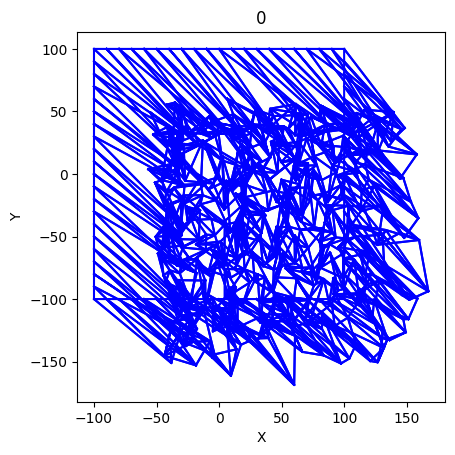

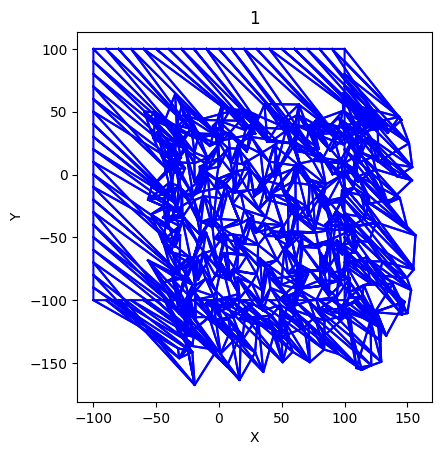

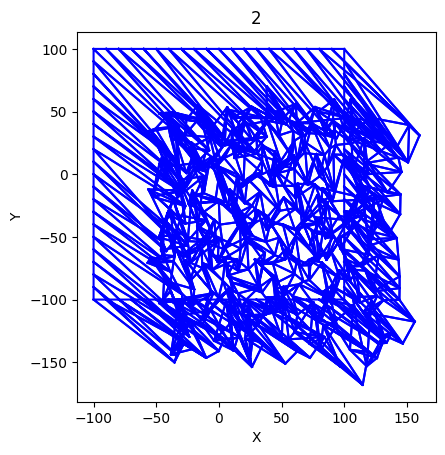

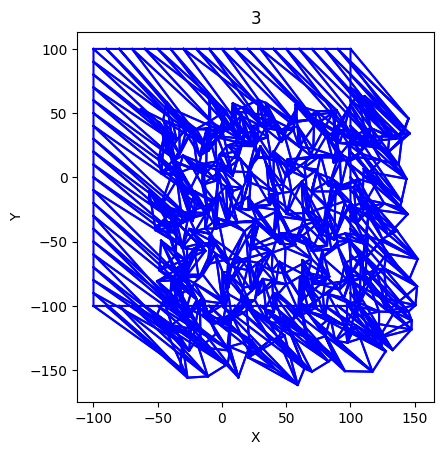

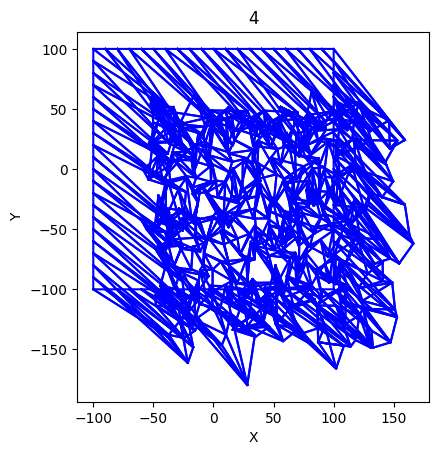

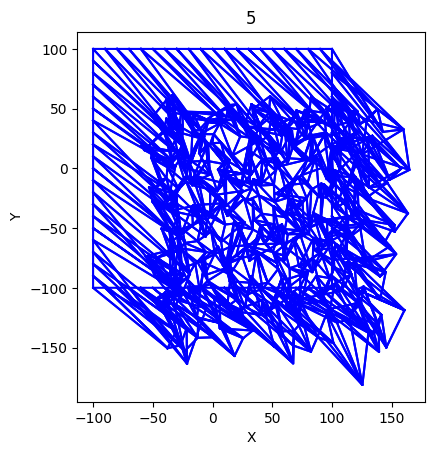

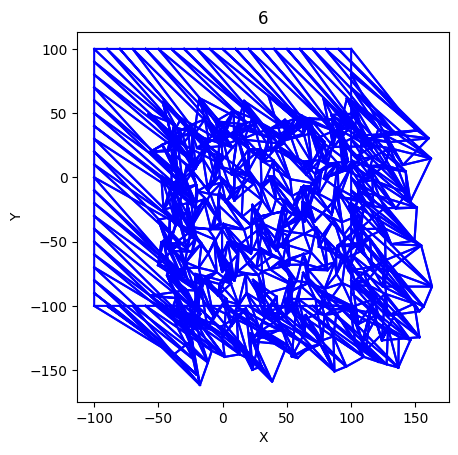

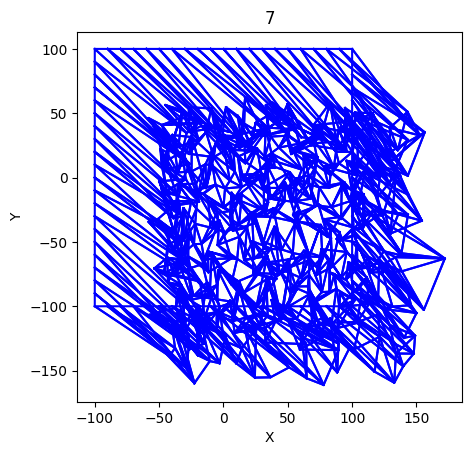

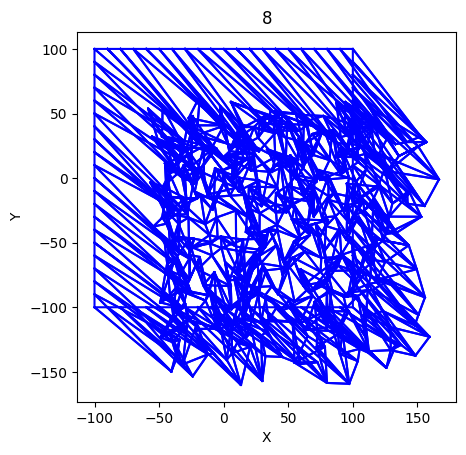

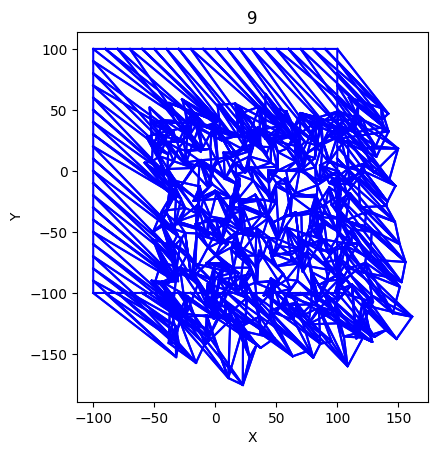

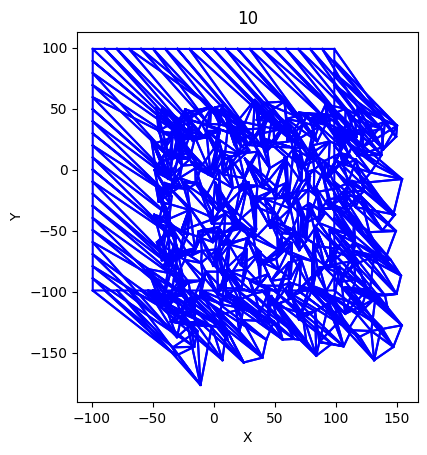

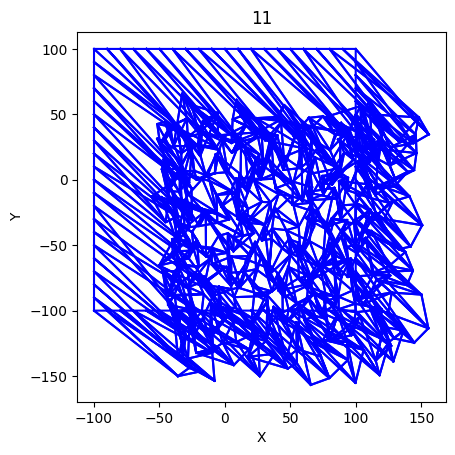

In [ ]:
for i in range(num_train_mesh):
    plot_mesh(train_mesh_data_list[i], f"{i}")

In [ ]:
# 100epochで最適化されたメッシュを10個生成する
test_mesh_data_lists = [copy.deepcopy(test_mesh_data_list) for _ in range(10)]

for trial in range(num_trial):
    for epoch in tqdm(range(num_test_epoch)):
        test_mesh_data_lists = test(device, trial, test_mesh_data_lists)


100%|██████████| 100/100 [42:57<00:00, 25.78s/it]


In [ ]:
best_mesh_data_list = []
num_test_mesh = len(test_vtk_files)
    
for i in tqdm(range(num_test_mesh)):
    q_hat_list = []
    for j in range(10):
        mesh = test_mesh_data_lists[j][i]

        # q_hat を求めるコード
        q_hat = calculate_q_hat(mesh)
        
        q_hat_list.append(q_hat)
        best = q_hat_list.index(min(q_hat_list))
        best_mesh_data_list.append(test_mesh_data_lists[best + 1][i])
    


    # best_mesh_data_list[i] のデータをvtkファイルで出力する
    vtk_output(best_mesh_data_list[i], f"optimized_{i}")

100%|██████████| 2/2 [00:09<00:00,  4.75s/it]


## 更新したメッシュを表示してみる

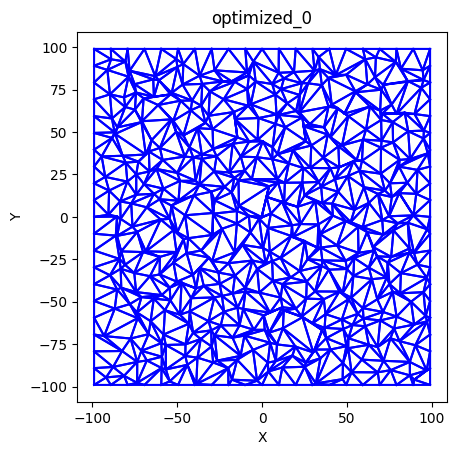

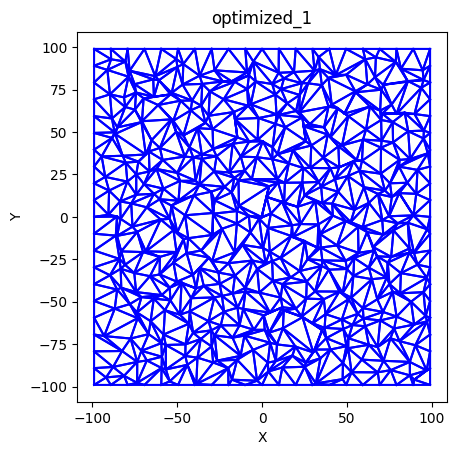

In [ ]:
for i in range(num_test_mesh):
    plot_mesh(best_mesh_data_list[i], f"optimized_{i}")

# 元のメッシュから座標が変わっているか確認する

In [ ]:
# for i in range(num_test_mesh):
#     print(test_mesh_data_list[i].coordinates.size())
#     print(best_mesh_data_list[i].coordinates.size())


In [ ]:

for i in range(num_test_mesh):
    if torch.equal(test_mesh_data_list[i].coordinates, best_mesh_data_list[i].coordinates):
        print("Not updated!!")
    
    else:
         print("Updated")

Updated
Updated
